<a href="https://colab.research.google.com/github/GVSU-CIS635/GVSU-CIS635-Project-Team-Data_Alliance/blob/main/final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from statistics import mean, stdev
from google.colab import drive
drive.mount('/content/drive')

import random
import os
from statsmodels.tsa.arima.model import ARIMA
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, LayerNormalization, Conv1D, MaxPooling1D, Flatten, MultiHeadAttention, Input, GlobalAveragePooling1D, Concatenate, Attention
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams

Mounted at /content/drive


In [3]:
rcParams["figure.figsize"] = 15, 6
rcParams["axes.titlesize"] = "xx-large"
rcParams["axes.titleweight"] = "bold"
rcParams["legend.loc"] = "upper left"

# Setting random seeds for reproducibility
seed_value = 42
os.environ["PYTHONHASHSEED"] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

l2_reg=0.001

In [179]:
df_streamflow = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Final Project/streamflow.csv', header = 0, names = ['id','year','month','day','date','q(m3/s)'])
display(df_streamflow.head())
print('\nThis dataset contains', df_streamflow.shape[0], 'rows and', df_streamflow.shape[1], 'columns')

,id,year,month,day,date,q(m3/s)
0,11963,1967,1,1,1967-01-01,2690.0
1,11964,1967,1,2,1967-01-02,2650.0
2,11965,1967,1,3,1967-01-03,2650.0
3,11966,1967,1,4,1967-01-04,2610.0
4,11967,1967,1,5,1967-01-05,2570.0



This dataset contains 18628 rows and 6 columns


In [180]:
#Attribute Classification
Categorical = ['id','year','month','day','date']
Numeric = ['q(m3/s)']

#Identify duplicates and drop them
duplication = df_streamflow[df_streamflow.duplicated(keep=False)]
print(f"df_streamflow dataframe has {duplication.shape[0]} duplicated samples.")

# df_streamflow.drop_duplicates()

df_streamflow dataframe has 0 duplicated samples.


In [181]:
#Exploratory Data Analysis
df_streamflow.info()

#print descriptive statisics
display(df_streamflow.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18628 entries, 0 to 18627
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       18628 non-null  int64  
 1   year     18628 non-null  int64  
 2   month    18628 non-null  int64  
 3   day      18628 non-null  int64  
 4   date     18628 non-null  object 
 5   q(m3/s)  18040 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 873.3+ KB


,id,year,month,day,q(m3/s)
count,18628.000000,18628.00000,18628.000000,18628.000000,18040.000000
mean,21276.500000,1992.00000,6.522869,15.729815,10671.594654
std,5377.584743,14.72017,3.448812,8.800403,14275.949377
min,11963.000000,1967.00000,1.000000,1.000000,182.840000
25%,16619.750000,1979.00000,4.000000,8.000000,1419.000000
50%,21276.500000,1992.00000,7.000000,16.000000,3060.000000
75%,25933.250000,2005.00000,10.000000,23.000000,15300.000000
max,30590.000000,2017.00000,12.000000,31.000000,79059.000000


In [182]:
#Identify missing values
df_streamflow[df_streamflow.columns].isin([np.NaN]).sum().sort_values(ascending = False)

q(m3/s)    588
id           0
year         0
month        0
day          0
date         0
dtype: int64

<ipython-input-183-7bfc5d746ffc>:12: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(14)


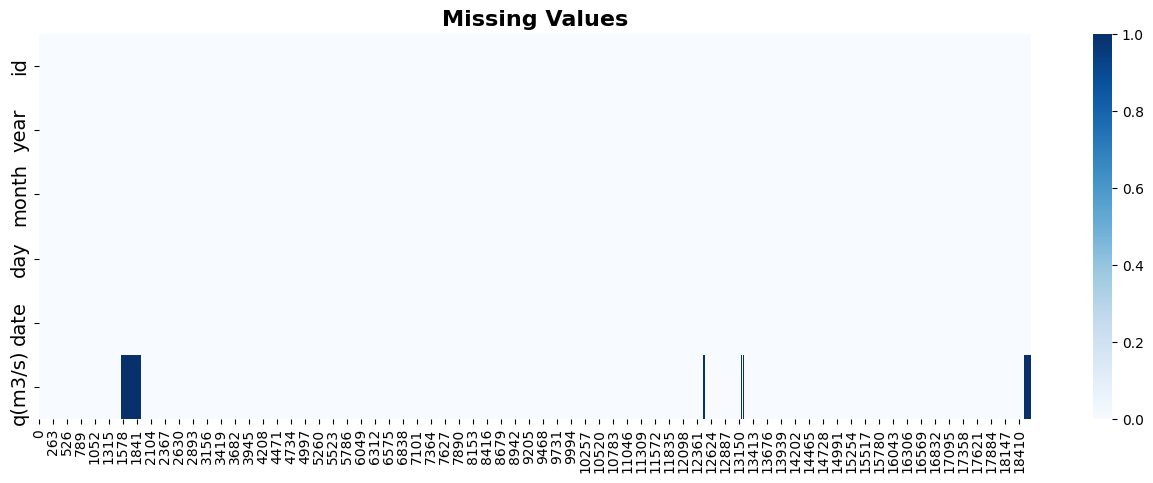

In [183]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error

#view missing values in a graph
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,5))

sns.heatmap(df_streamflow.T.isna(), cmap='Blues')
ax.set_title('Missing Values', fontsize=16)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
plt.show()

Text(0, 0.5, 'Q (m3/s)')

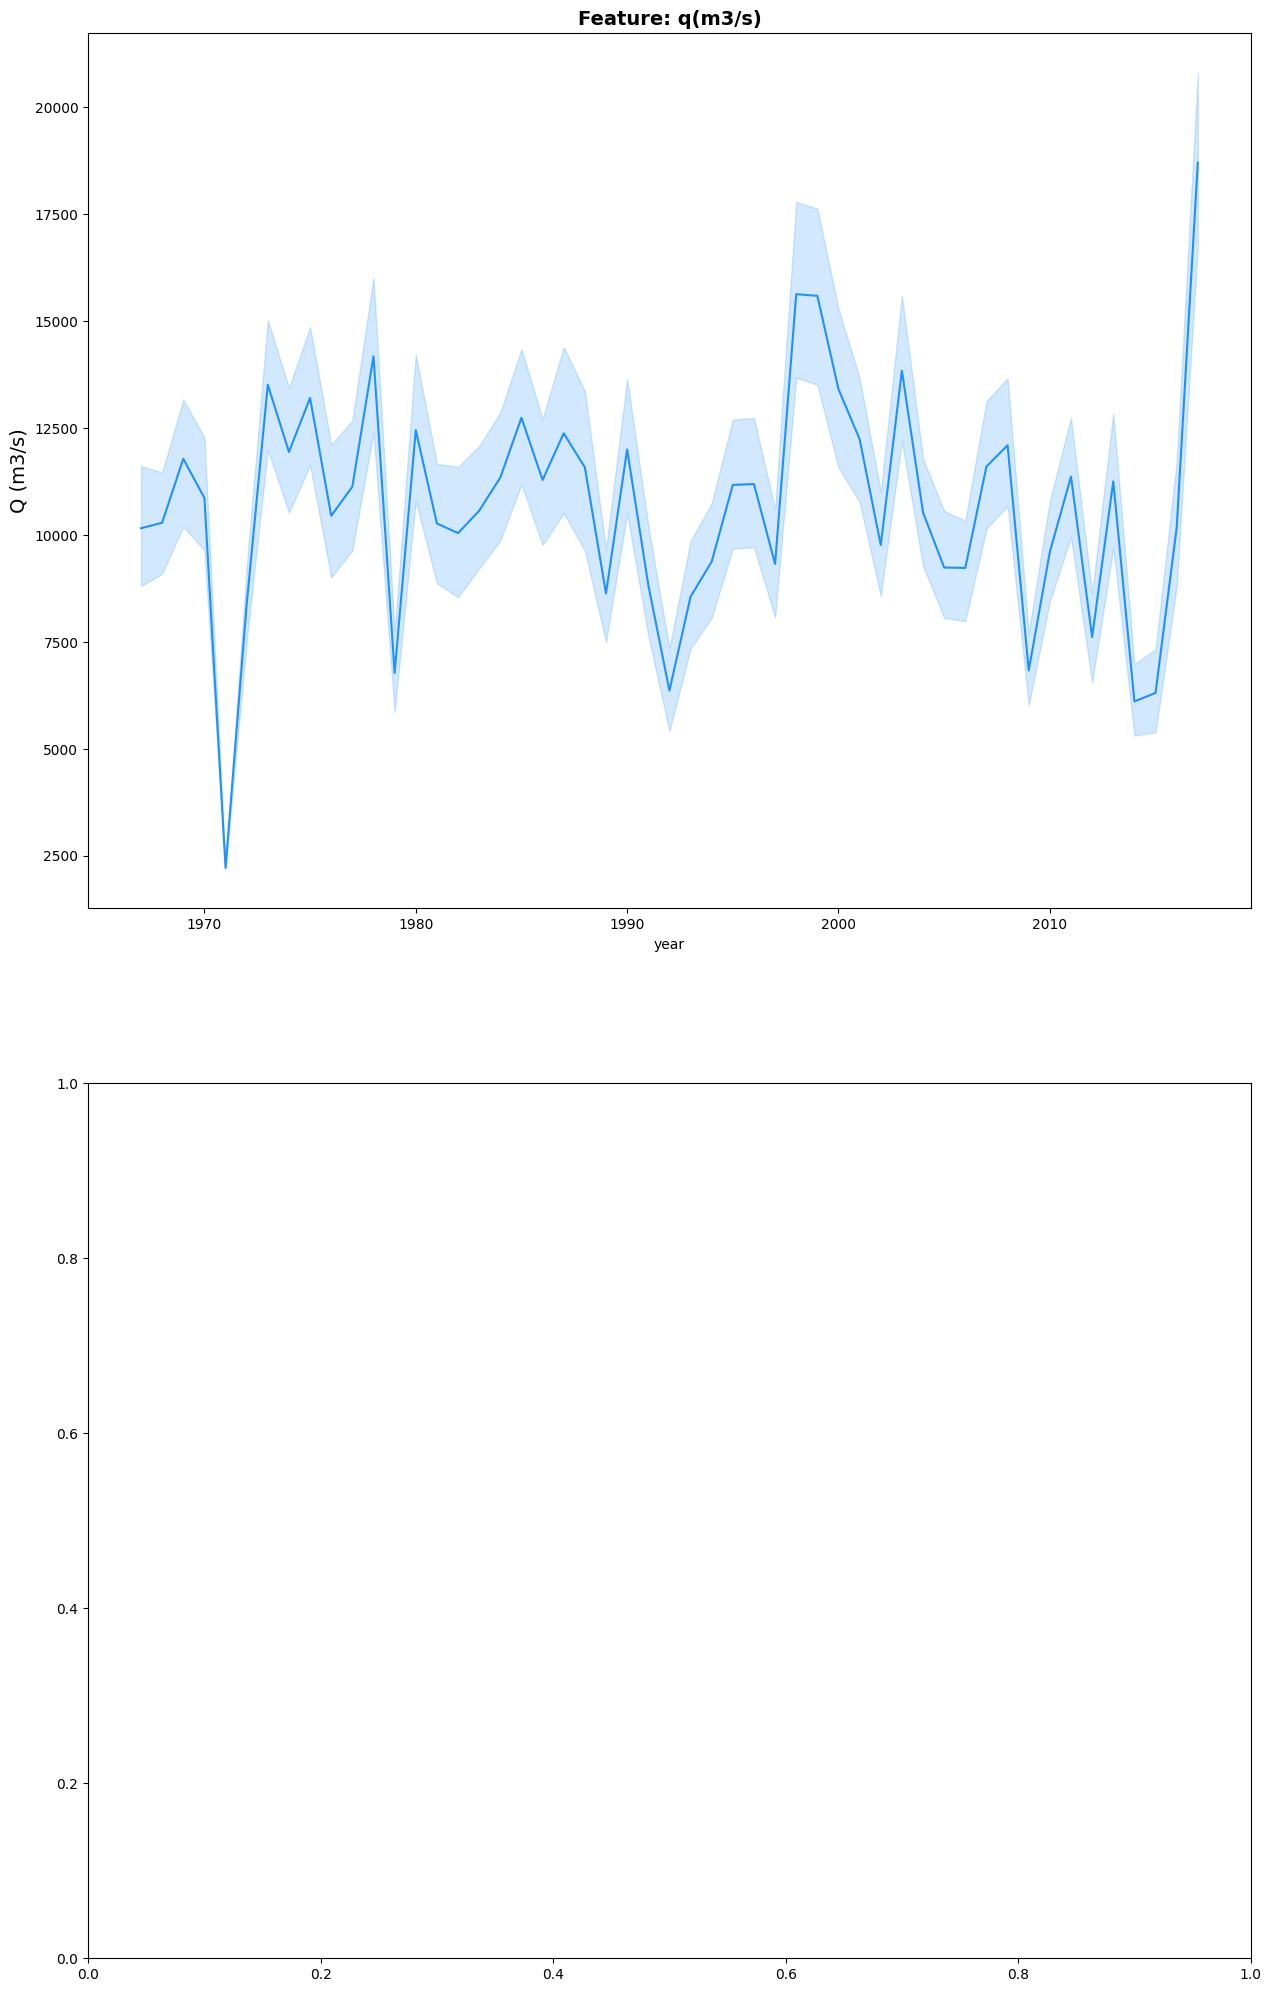

In [184]:
# To complete the data, as naive method, we will use ffill
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 25))

sns.lineplot(x=df_streamflow['year'], y=df_streamflow['q(m3/s)'].fillna(method='ffill'), ax=ax[0], color='dodgerblue')
ax[0].set_title('Feature: {}'.format('q(m3/s)'), fontsize=14)
ax[0].set_ylabel(ylabel= 'Q (m3/s)', fontsize=14)

In [189]:
df_streamflow['date'] = pd.to_datetime(df_streamflow['date'])

#Replace missing values with median value
median_imputer = SimpleImputer(missing_values=np.NaN,strategy='median')

df_streamflow['q(m3/s)'] = median_imputer.fit_transform(df_streamflow[['q(m3/s)']])
display(df_streamflow)

,id,year,month,day,date,q(m3/s)
0,11963,1967,1,1,1967-01-01,2690.0
1,11964,1967,1,2,1967-01-02,2650.0
2,11965,1967,1,3,1967-01-03,2650.0
3,11966,1967,1,4,1967-01-04,2610.0
4,11967,1967,1,5,1967-01-05,2570.0
...,...,...,...,...,...,...
18623,30586,2017,12,27,2017-12-27,3060.0
18624,30587,2017,12,28,2017-12-28,3060.0
18625,30588,2017,12,29,2017-12-29,3060.0
18626,30589,2017,12,30,2017-12-30,3060.0


In [190]:
#Convert q(m3/s) datatype to int
df_streamflow['q(m3/s)'] = df_streamflow['q(m3/s)'].astype(int)
display(df_streamflow)

,id,year,month,day,date,q(m3/s)
0,11963,1967,1,1,1967-01-01,2690
1,11964,1967,1,2,1967-01-02,2650
2,11965,1967,1,3,1967-01-03,2650
3,11966,1967,1,4,1967-01-04,2610
4,11967,1967,1,5,1967-01-05,2570
...,...,...,...,...,...,...
18623,30586,2017,12,27,2017-12-27,3060
18624,30587,2017,12,28,2017-12-28,3060
18625,30588,2017,12,29,2017-12-29,3060
18626,30589,2017,12,30,2017-12-30,3060


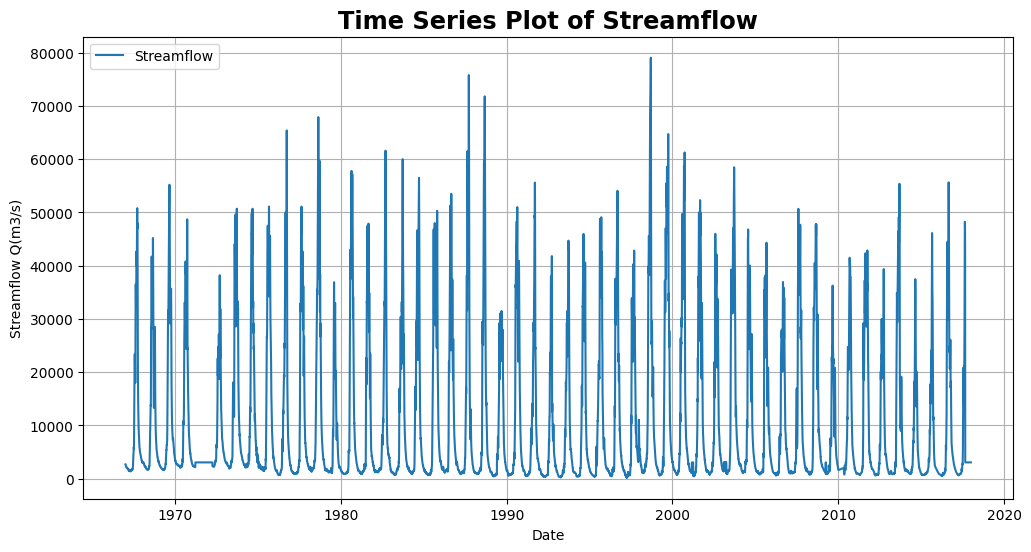

In [191]:
# Create a time series plot
plt.figure(figsize=(12, 6))
plt.plot(df_streamflow['date'], df_streamflow['q(m3/s)'], label='Streamflow')
plt.title('Time Series Plot of Streamflow')
plt.xlabel('Date')
plt.ylabel('Streamflow Q(m3/s)')
plt.legend()
plt.grid(True)
plt.show()

In [192]:
# Set 'Date' as the index for time series analysis
df_streamflow.set_index('date', inplace=True)

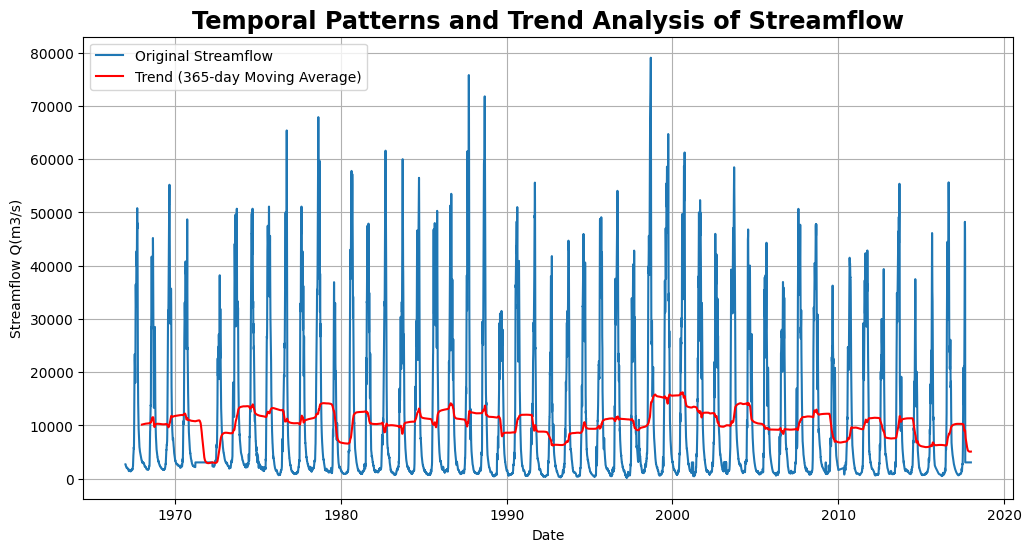

In [37]:
# Explore overall trend using a rolling mean (moving average)
rolling_mean = df_streamflow['q(m3/s)'].rolling(window=365).mean()  # 365-day moving average for annual trend
trend_df = pd.DataFrame({'Streamflow': df_streamflow['q(m3/s)'], 'Trend': rolling_mean})

# Plot the original streamflow and the trend
plt.figure(figsize=(12, 6))
plt.plot(df_streamflow.index, df_streamflow['q(m3/s)'], label='Original Streamflow')
plt.plot(trend_df.index, trend_df['Trend'], label='Trend (365-day Moving Average)', color='red')
plt.title('Temporal Patterns and Trend Analysis of Streamflow')
plt.xlabel('Date')
plt.ylabel('Streamflow Q(m3/s)')
plt.legend()
plt.grid(True)
plt.show()

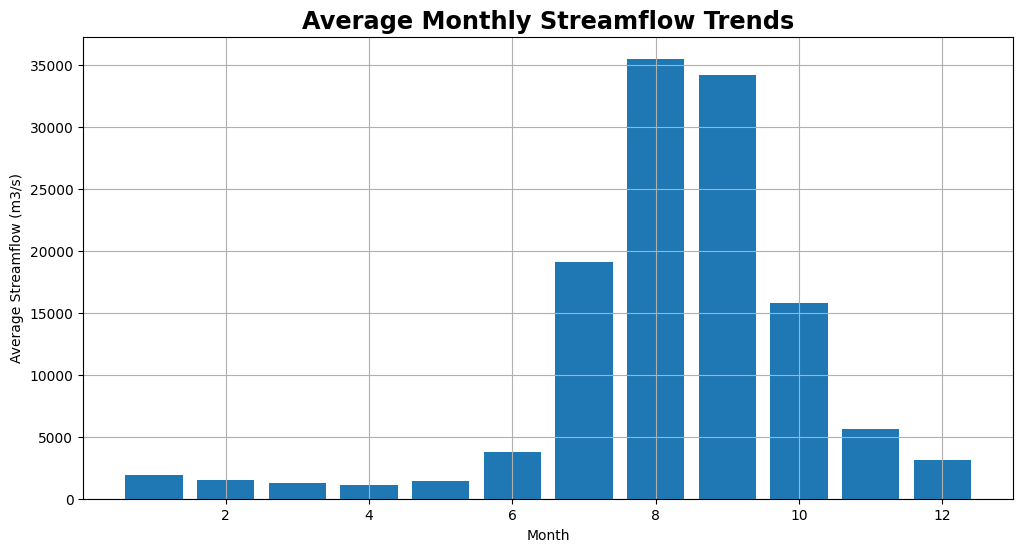

In [38]:
# Explore trends in different months
monthly_trends = df_streamflow.groupby(df_streamflow.index.month)['q(m3/s)'].mean()

# Plot monthly trends
plt.figure(figsize=(12, 6))
plt.bar(monthly_trends.index, monthly_trends.values)
plt.title('Average Monthly Streamflow Trends')
plt.xlabel('Month')
plt.ylabel('Average Streamflow (m3/s)')
plt.grid(True)
plt.show()

In [39]:
X = df_streamflow.iloc[0:2000, 0:4]
y = df_streamflow.iloc[0:2000, 4:5]

kfold = KFold(n_splits=3, shuffle=True, random_state=42)
model = LogisticRegression()
lst_accuracy_scores = []

# display(df_streamflow.head())

# from sklearn.model_selection import  train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state= 46)


for train_index, test_index in kfold.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    lst_accuracy_scores.append(score)

print('List of possible accuracy:', lst_accuracy_scores)
print('\nMaximum Accuracy that can be obtained from this model is:',max(lst_accuracy_scores)*100, '%')
print('\nMinimum Accuracy:', min(lst_accuracy_scores)*100, '%')
print('\nOverall Accuracy:', mean(lst_accuracy_scores)*100, '%')
print('\nStandard Deviation is:', stdev(lst_accuracy_scores))

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel

List of possible accuracy: [0.20539730134932535, 0.1634182908545727, 0.21021021021021022]

Maximum Accuracy that can be obtained from this model is: 21.02102102102102 %

Minimum Accuracy: 16.34182908545727 %

Overall Accuracy: 19.300860080470276 %

Standard Deviation is: 0.025738703447034196


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [40]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

models = []

models.append(("KNN Classifier", KNeighborsClassifier(n_neighbors=5)))
models.append(("Decision Tree Classifier", DecisionTreeClassifier()))
models.append(("Random Forest Classifier", RandomForestClassifier(n_estimators=10, random_state=42)))
models.append(("Adaboost Classifier", AdaBoostClassifier(n_estimators=10, random_state=42)))
models.append(("Naive Baiyes Classifier", GaussianNB()))

for name, model in models:
  model.fit(X_train, y_train)
  accuracy = accuracy_score(y_test, model.predict(X_test))
  print("\n", name, "Accuracy:", accuracy * 100.0, '%')

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
<ipython-input-40-7e6969a728e8>:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)



 KNN Classifier Accuracy: 29.129129129129126 %

 Decision Tree Classifier Accuracy: 34.83483483483483 %

 Random Forest Classifier Accuracy: 34.53453453453454 %


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 Adaboost Classifier Accuracy: 10.21021021021021 %

 Naive Baiyes Classifier Accuracy: 24.174174174174173 %


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


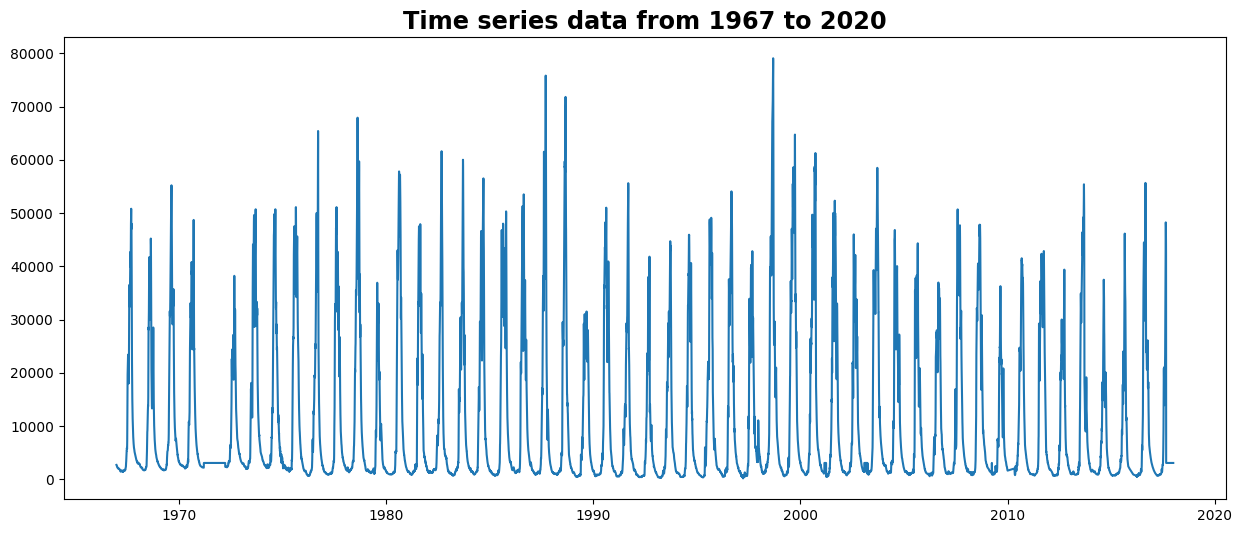

In [198]:
streamflow = df_streamflow['q(m3/s)']
plt.title("Time series data from 1967 to 2020")
plt.plot(streamflow)

In [42]:
split_validation = len(streamflow) - 12000
split_test = len(streamflow) - 6000
ts, ts_val, ts_test = (
    streamflow[0:split_validation],
    streamflow[split_validation:split_test],
    streamflow[split_test:],
)
print("Training %d, Validation %d, Test %d" % (len(ts), len(ts_val), len(ts_test)))
print(type(ts))

Training 6628, Validation 6000, Test 6000
<class 'pandas.core.series.Series'>


In [43]:
from statsmodels.tsa.stattools import adfuller


def test_stationarity(timeseries):
    # Determing rolling statistics
    rolmean = timeseries.rolling(window=12, center=False).mean()
    rolstd = timeseries.rolling(window=12, center=False).std()

    # Plot rolling statistics:
    orig = plt.plot(timeseries, color="blue", label="Original")
    mean = plt.plot(rolmean, color="red", label="Rolling Mean")
    std = plt.plot(rolstd, color="black", label="Rolling Std")
    plt.legend(loc="best")
    plt.title("Rolling Mean & Standard Deviation")
    plt.show(block=False)

    # Perform Dickey-Fuller test:
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

    if dftest[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

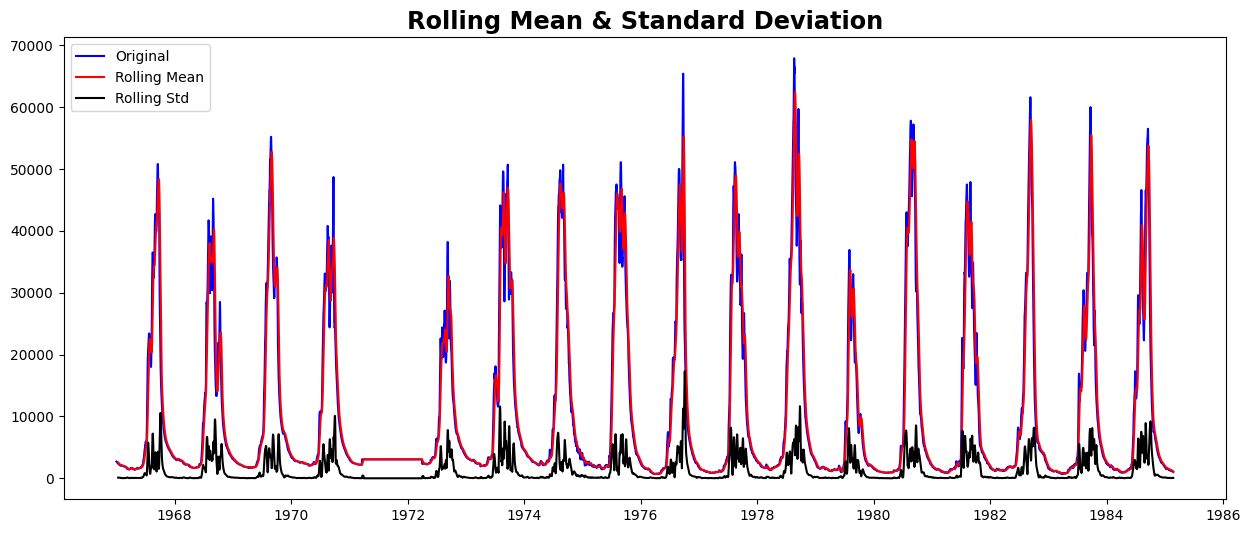

Results of Dickey-Fuller Test:
Test Statistic                -9.192941e+00
p-value                        2.099401e-15
#Lags Used                     3.500000e+01
Number of Observations Used    6.592000e+03
Critical Value (1%)           -3.431342e+00
Critical Value (5%)           -2.861979e+00
Critical Value (10%)          -2.567003e+00
dtype: float64
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [44]:
#Test stationery of time series data
test_stationarity(ts)

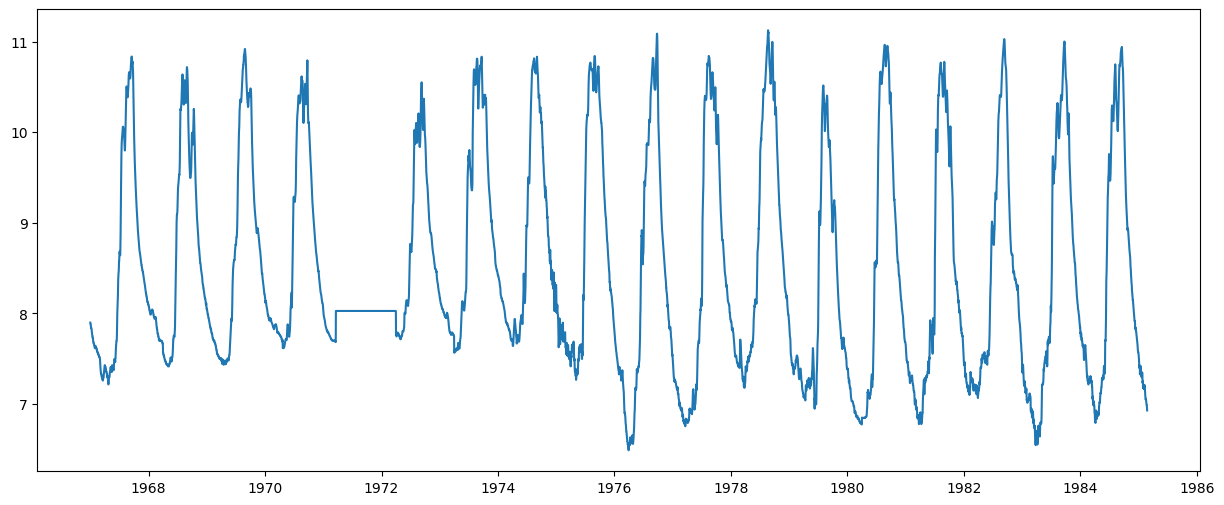

In [45]:
#Making time series stationary

#Estimating and eliminating trend
ts_log = np.log(ts)
plt.plot(ts_log)

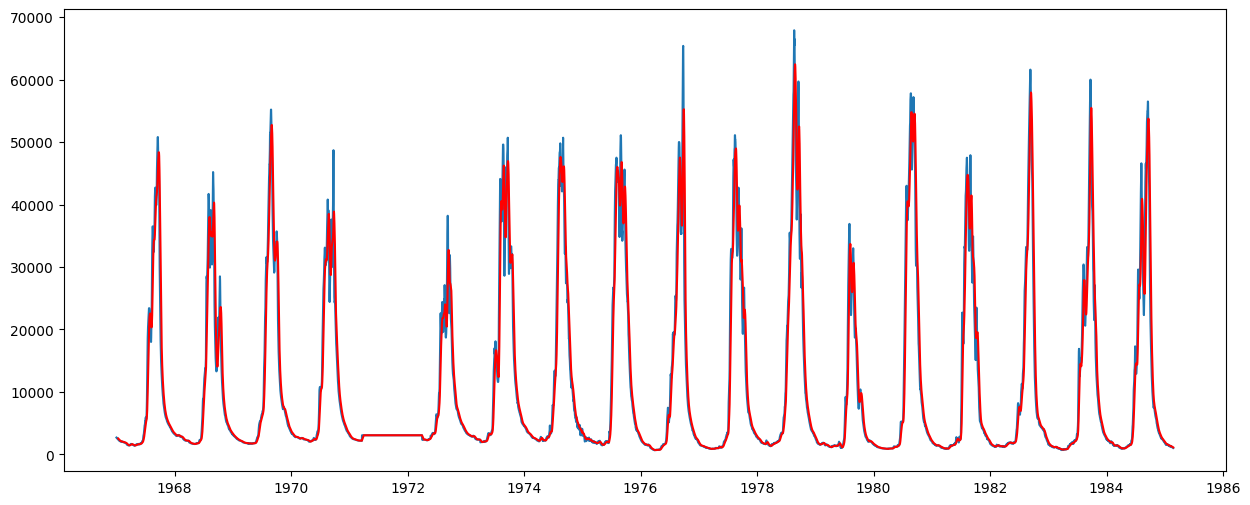

In [46]:
#Moving Average
moving_avg = ts.rolling(window=12, center=False).mean()
plt.plot(ts)
plt.plot(moving_avg, color="red")

In [47]:
ts_moving_avg_diff = ts - moving_avg
ts_moving_avg_diff.head(12)

date
1967-01-01           NaN
1967-01-02           NaN
1967-01-03           NaN
1967-01-04           NaN
1967-01-05           NaN
1967-01-06           NaN
1967-01-07           NaN
1967-01-08           NaN
1967-01-09           NaN
1967-01-10           NaN
1967-01-11           NaN
1967-01-12   -161.666667
Name: q(m3/s), dtype: float64

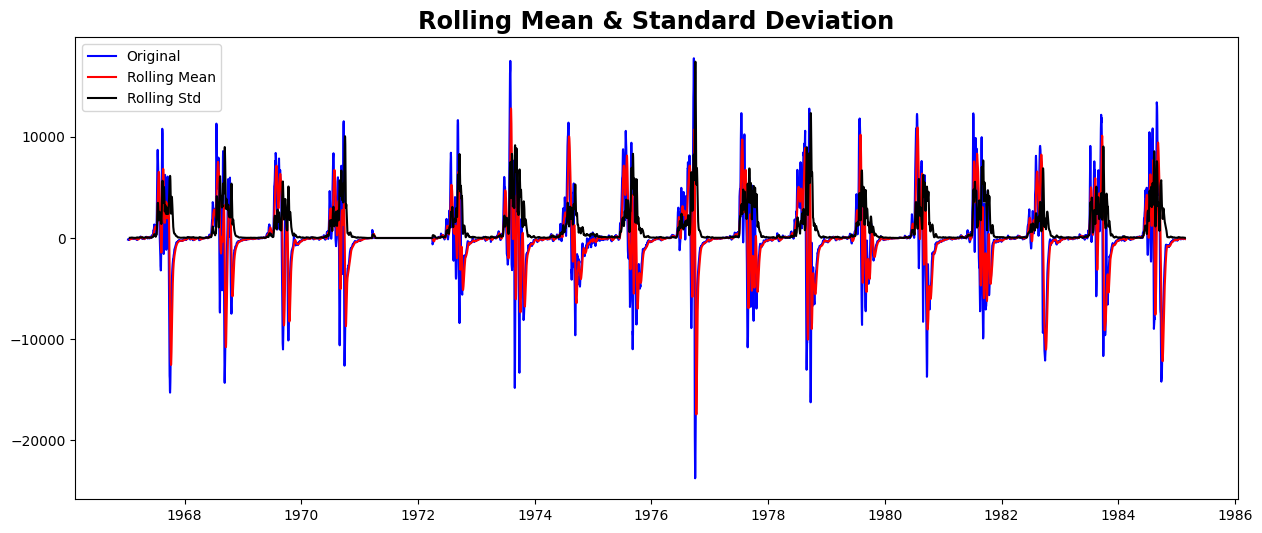

Results of Dickey-Fuller Test:
Test Statistic                -1.077304e+01
p-value                        2.357559e-19
#Lags Used                     3.500000e+01
Number of Observations Used    6.581000e+03
Critical Value (1%)           -3.431344e+00
Critical Value (5%)           -2.861979e+00
Critical Value (10%)          -2.567004e+00
dtype: float64
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [48]:
ts_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_moving_avg_diff)

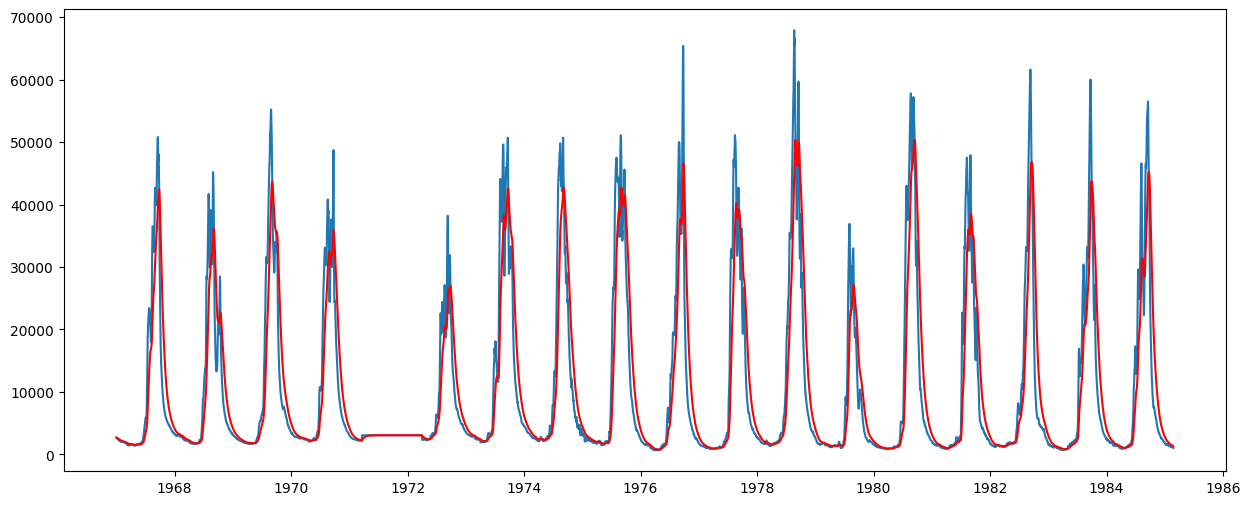

In [49]:
expwighted_avg = ts.ewm(halflife=12, min_periods=0, adjust=True, ignore_na=False).mean()
plt.plot(ts)
plt.plot(expwighted_avg, color="red")

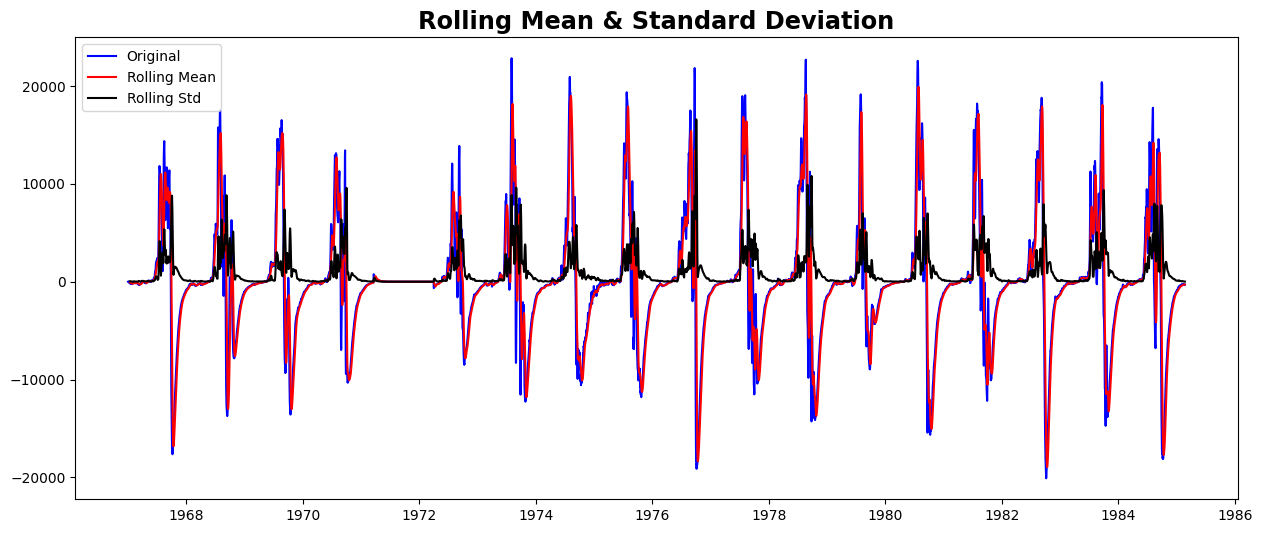

Results of Dickey-Fuller Test:
Test Statistic                -1.048773e+01
p-value                        1.168486e-18
#Lags Used                     3.500000e+01
Number of Observations Used    6.592000e+03
Critical Value (1%)           -3.431342e+00
Critical Value (5%)           -2.861979e+00
Critical Value (10%)          -2.567003e+00
dtype: float64
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [50]:
ts_ewma_diff = ts - expwighted_avg
test_stationarity(ts_ewma_diff)

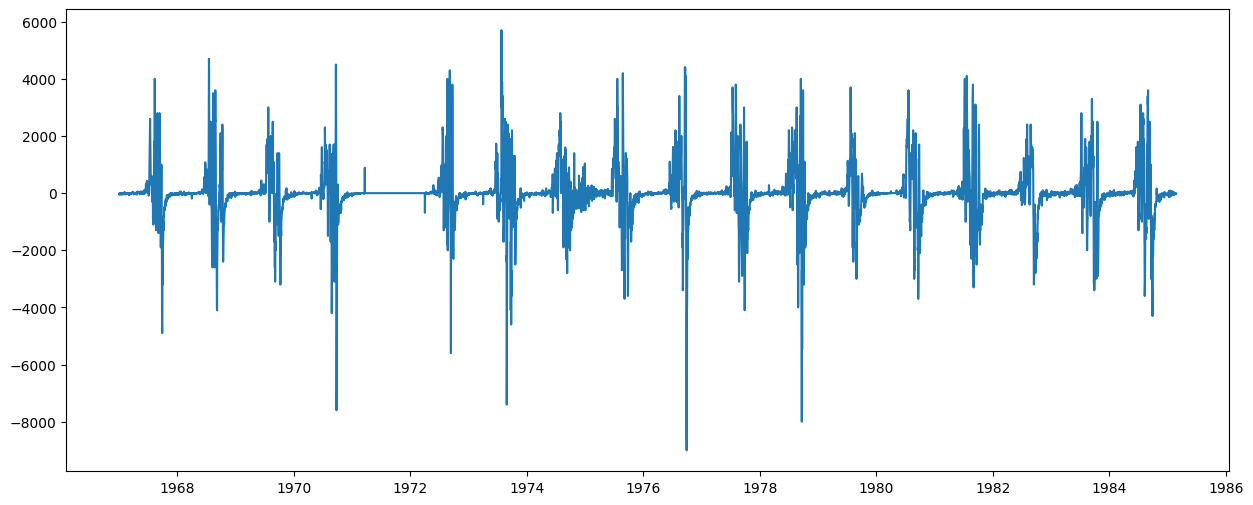

In [51]:
#Differencing

ts_diff = ts - ts.shift()
plt.plot(ts_diff)

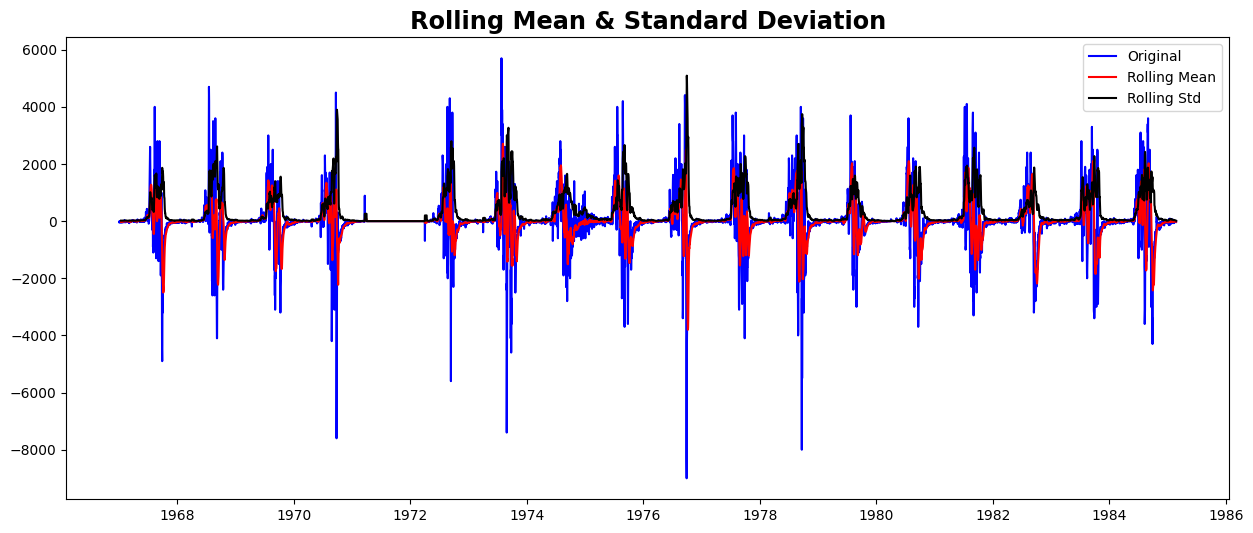

Results of Dickey-Fuller Test:
Test Statistic                -1.067116e+01
p-value                        4.163690e-19
#Lags Used                     3.400000e+01
Number of Observations Used    6.592000e+03
Critical Value (1%)           -3.431342e+00
Critical Value (5%)           -2.861979e+00
Critical Value (10%)          -2.567003e+00
dtype: float64
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [52]:
ts_diff.dropna(inplace=True)
test_stationarity(ts_diff)

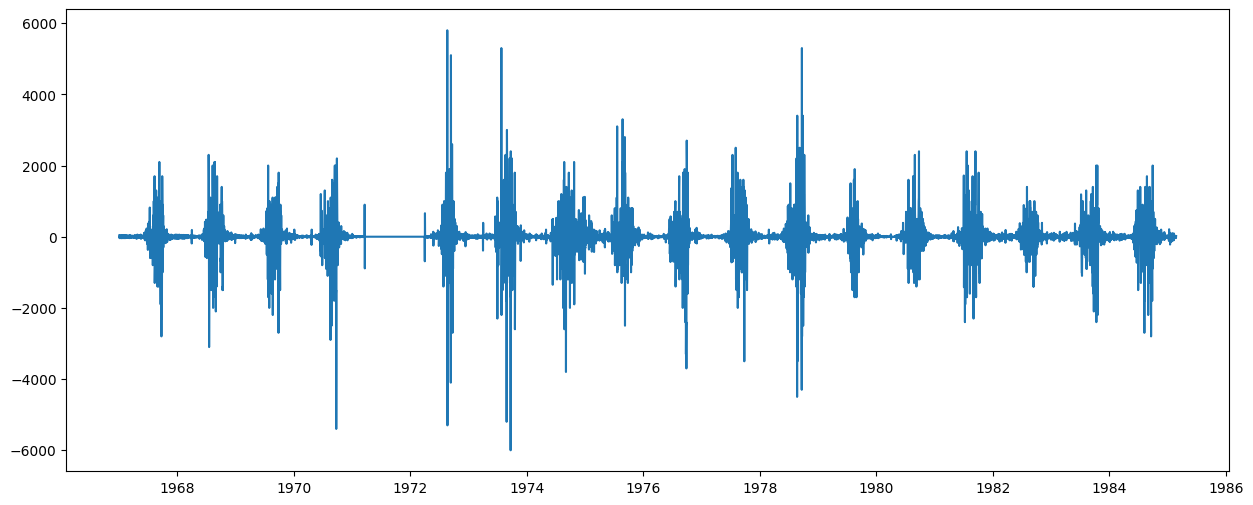

In [53]:
ts_diff2 = ts - ts.shift() - (ts.shift() - ts.shift(2))
plt.plot(ts_diff2)

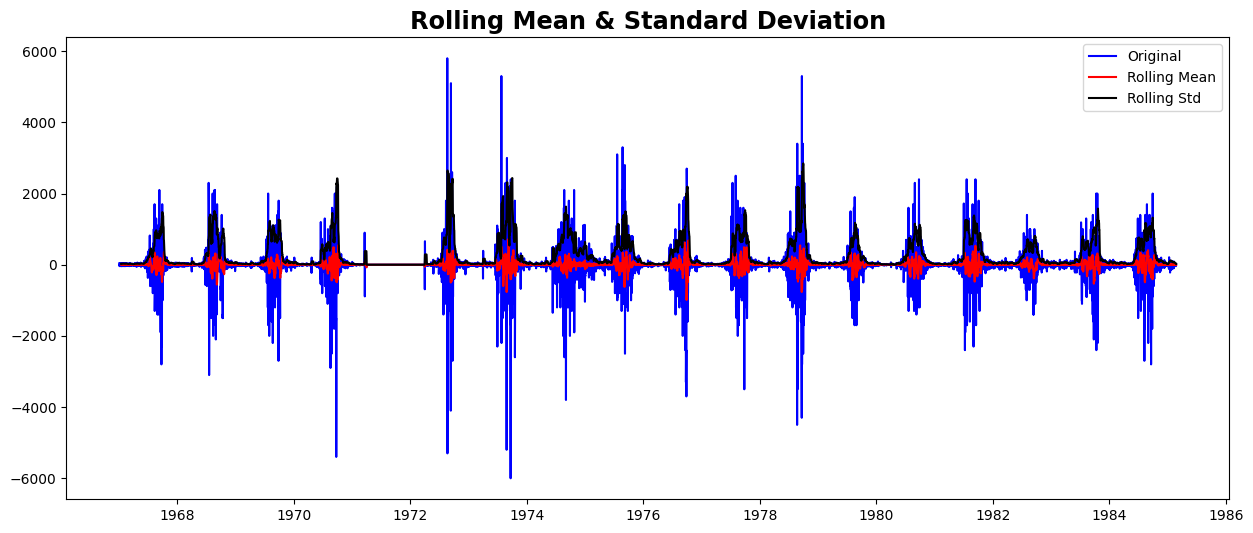

Results of Dickey-Fuller Test:
Test Statistic                  -22.922902
p-value                           0.000000
#Lags Used                       33.000000
Number of Observations Used    6592.000000
Critical Value (1%)              -3.431342
Critical Value (5%)              -2.861979
Critical Value (10%)             -2.567003
dtype: float64
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [54]:
ts_diff2.dropna(inplace=True)
test_stationarity(ts_diff2)

In [55]:
# ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

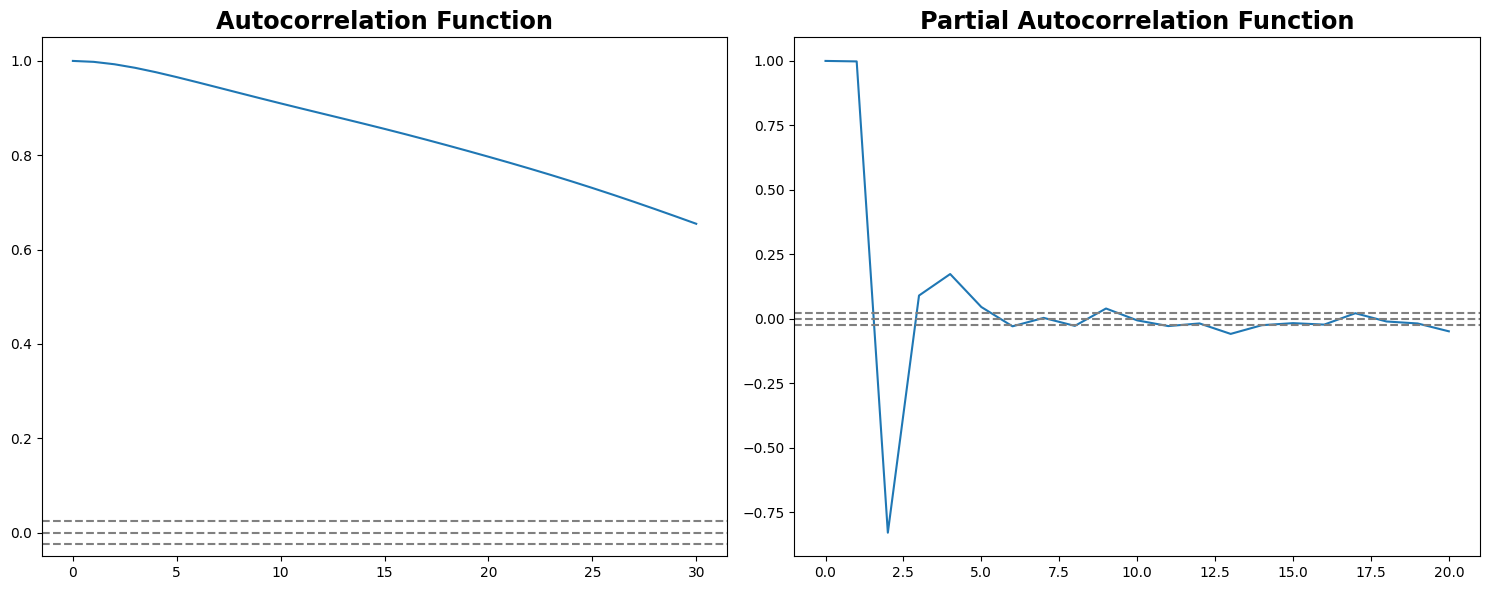

In [56]:
#Forecasting time series
lag_acf = acf(ts, nlags=30)
lag_pacf = pacf(ts, nlags=20, method="ols")

# Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle="--", color="gray")
plt.axhline(y=-1.96 / np.sqrt(len(ts_diff2)), linestyle="--", color="gray")
plt.axhline(y=1.96 / np.sqrt(len(ts_diff2)), linestyle="--", color="gray")
plt.title("Autocorrelation Function")

# Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle="--", color="gray")
plt.axhline(y=-1.96 / np.sqrt(len(ts_diff2)), linestyle="--", color="gray")
plt.axhline(y=1.96 / np.sqrt(len(ts_diff2)), linestyle="--", color="gray")
plt.title("Partial Autocorrelation Function")
plt.tight_layout()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


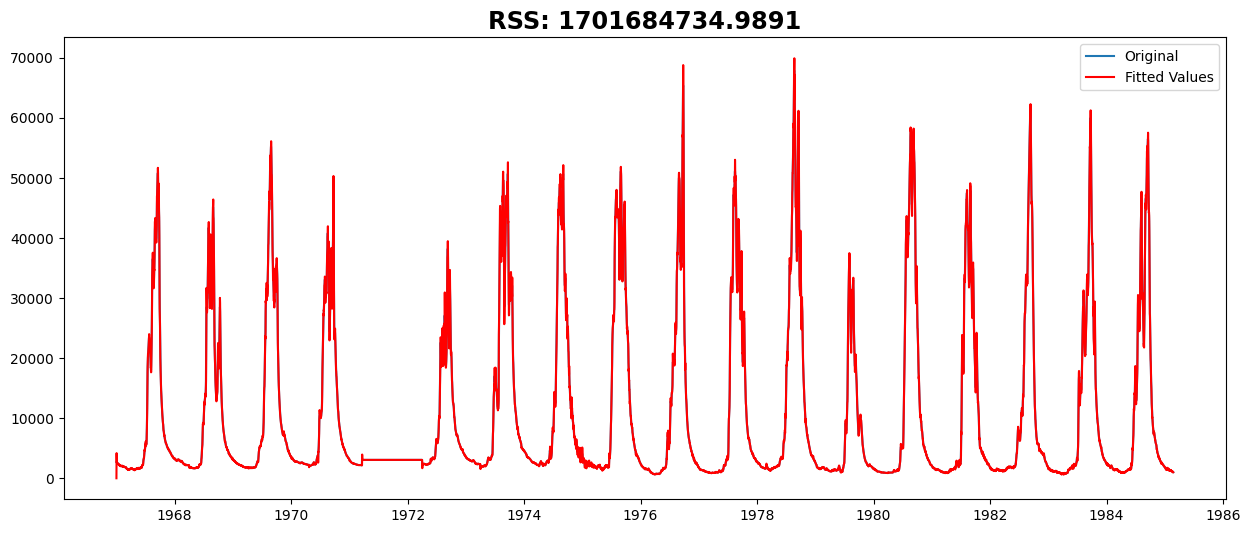

In [57]:
#AR Model

from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(ts, order=(2, 2, 0))
results_AR = model.fit()
plt.plot(ts, label="Original")
plt.plot(results_AR.fittedvalues, color="red", label="Fitted Values")
plt.title("RSS: %.4f" % sum((results_AR.fittedvalues - ts) ** 2))
plt.legend(loc="best")
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Text(0.5, 1.0, 'RSS: 1558115179.7853')

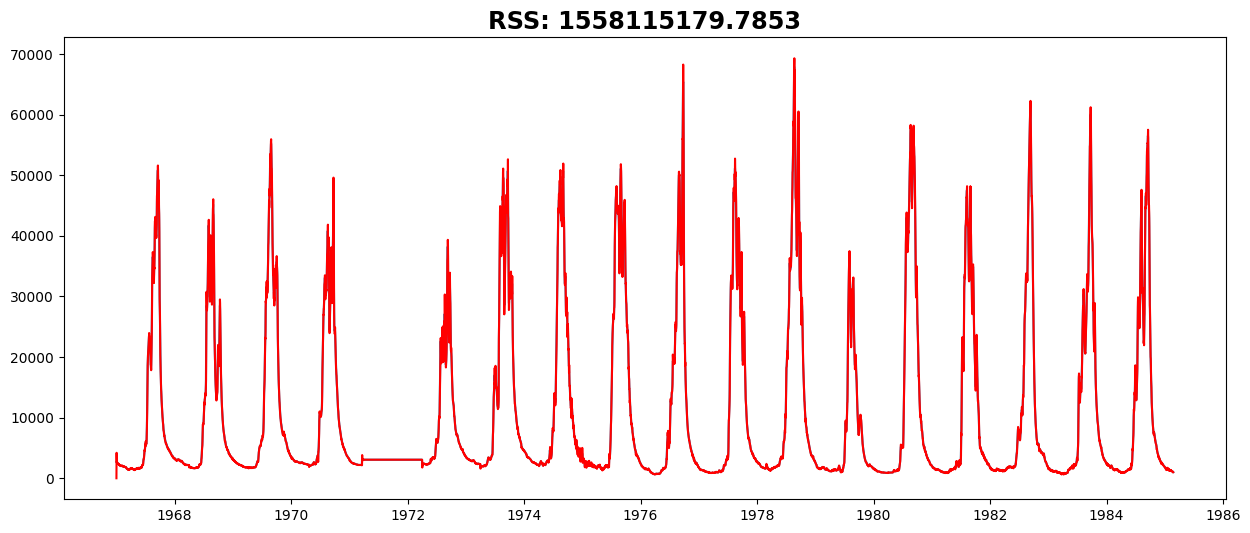

In [58]:
#MA Model

model = ARIMA(ts, order=(0, 2, 5))
results_MA = model.fit()
plt.plot(ts)
plt.plot(results_MA.fittedvalues, color="red")
plt.title("RSS: %.4f" % sum((results_MA.fittedvalues - ts) ** 2))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  

Text(0.5, 1.0, 'RSS: 1495292616.1695')

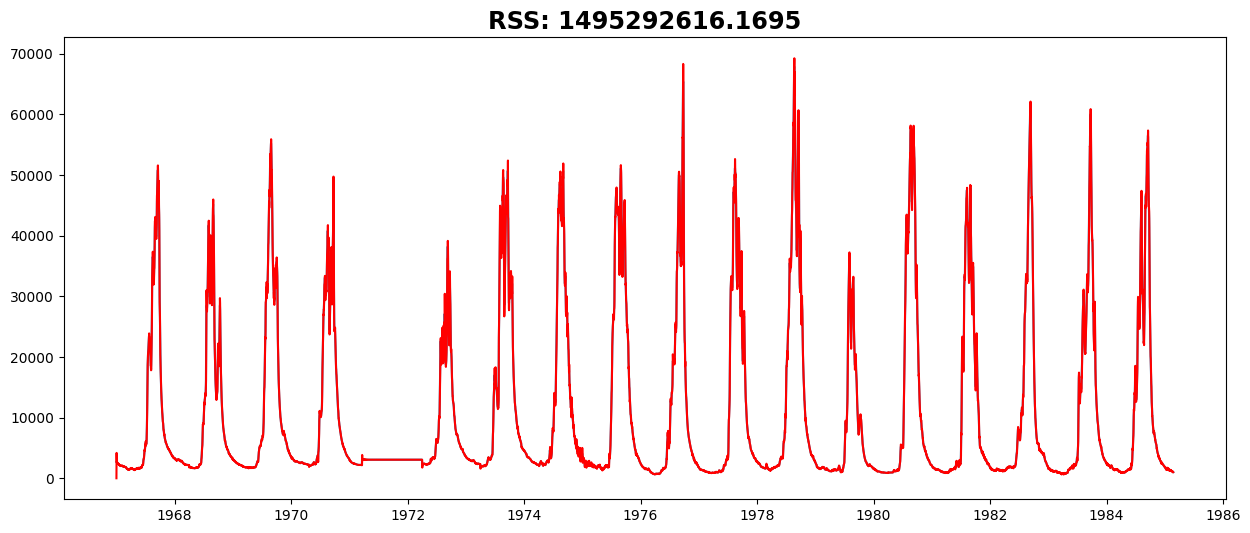

In [59]:
model = ARIMA(ts, order=(2, 2, 5))
results_ARIMA = model.fit()
plt.plot(ts)
plt.plot(results_ARIMA.fittedvalues, color="red")
plt.title("RSS: %.4f" % sum((results_ARIMA.fittedvalues - ts) ** 2))

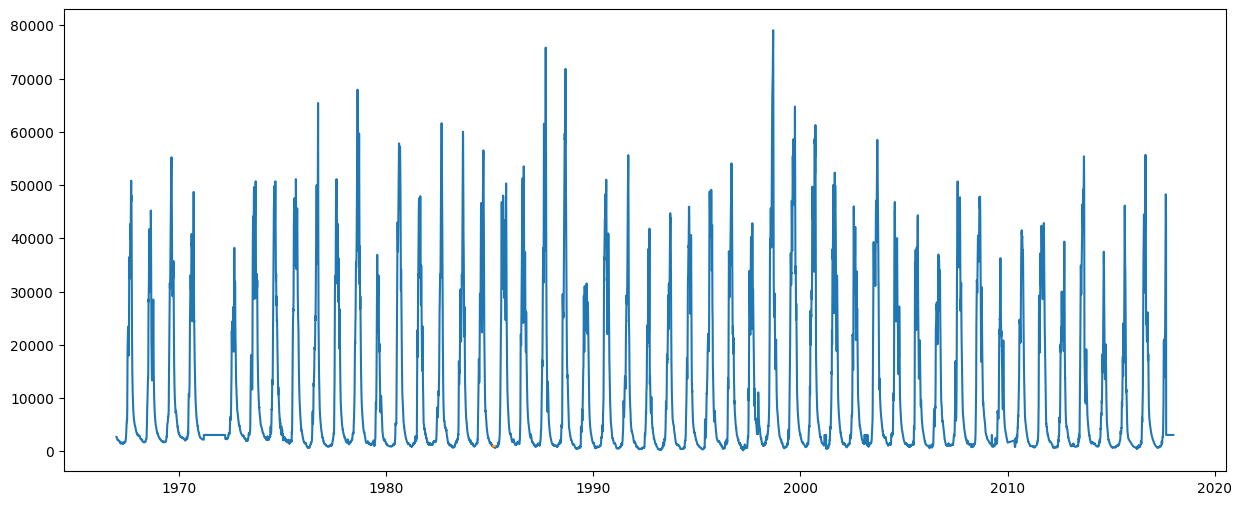

In [61]:
#Multi-Step Forecasting
yhat_val = results_ARIMA.forecast(steps=12)
yhat_test = results_ARIMA.forecast(steps=36)[-24:]

plt.plot(streamflow)
plt.plot(yhat_val, color="red")
plt.plot(yhat_test, color="orange")

In [63]:
#Recursive Forecasting
# training = ts
# for i in range(split_validation, len(streamflow)):
#     model = ARIMA(training, order=(2, 2, 3))
#     results_ARIMA = model.fit()
#     forecast = results_ARIMA.forecast(steps=1)
#     training = pd.concat([training, forecast])
# plt.plot(streamflow)
# plt.plot(training)

In [153]:

data_train, data_test = (
    df_streamflow.iloc[0:8000,4:5],
    df_streamflow.iloc[8000:13000,4:5],
)
print(f"Training {len(data_train)}, Test {len(data_test)}")
print(type(data_train))

Training 8000, Test 5000
<class 'pandas.core.frame.DataFrame'>


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


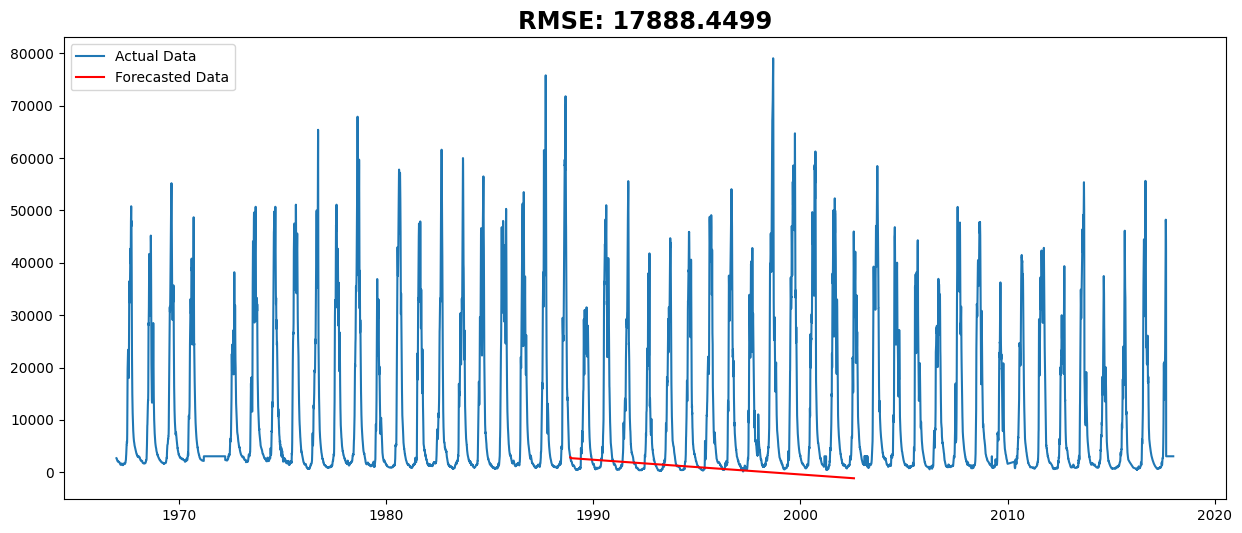

In [154]:
#ARIMA Model
model = ARIMA(data_train, order=(2, 2, 11))
results_ARIMA = model.fit()
yhat = results_ARIMA.forecast(steps=5000)
plt.plot(streamflow, label="Actual Data")
plt.plot(yhat, color="red", label="Forecasted Data")

# Calculating the RMSE (Root Mean Squared Error)
rmse = mean_squared_error(data_test["q(m3/s)"], yhat, squared=False)
plt.title(f"RMSE: {rmse:.4f}")
plt.legend()
plt.show()

(18628, 5)


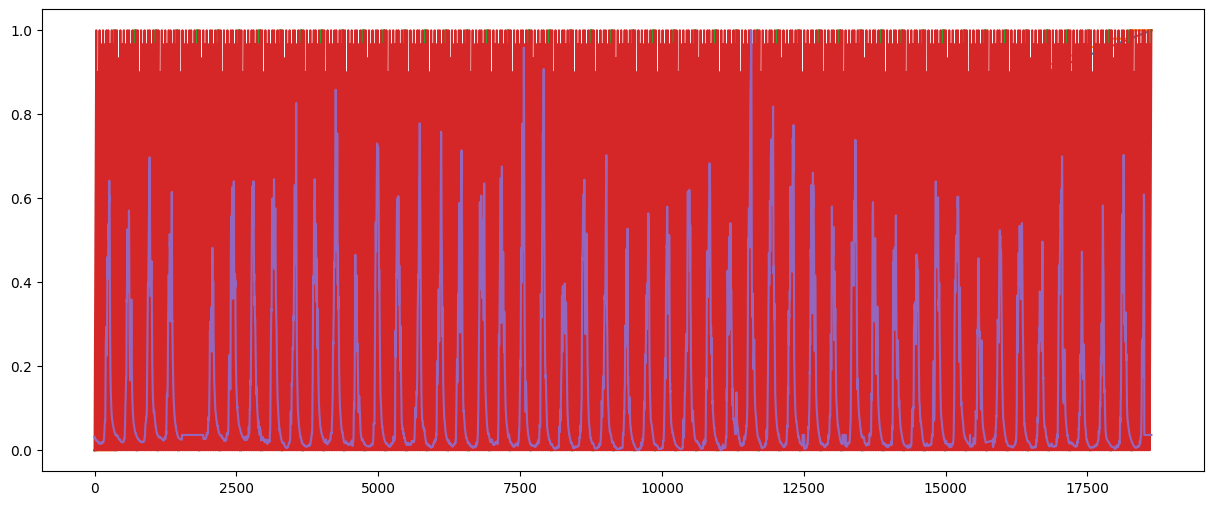

In [199]:
#Neural Networks

#Data Normalization
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_streamflow)
print(scaled_data.shape)
plt.plot(scaled_data)

In [200]:
def create_dataset(sequence, look_back=1):
    X, y = [], []
    for i in range(len(sequence) - look_back):
        end_ix = i + look_back
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [212]:
# Using past 12 time steps to predict the next step
look_back = 12

X, y = create_dataset(scaled_data, look_back)
print("(samples, timesteps, features): " + str(X.shape))

(samples, timesteps, features): (18616, 12, 5)
